# Importing required libraries 

In [1]:
from kiteconnect import KiteConnect,KiteTicker
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import os 
import time
from time import sleep 
import statsmodels.api as sm
from pyotp import TOTP
from datetime import datetime
from urllib.parse import urlparse,parse_qs
import pandas as pd 
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

c:\Users\rsurs\miniconda3\envs\algo\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
def get_curr_path(folder_name):
    curr_dir = os.getcwd()
    curr_path = os.path.join(curr_dir,folder_name)
    return curr_path

def get_credentials(curr_path,file_name):
    file_dir = os.path.join(curr_path,file_name)
    file = open(file_dir,'r').read().split()
    api_key = file[0]
    api_secret = file[1]
    user_name = file[2]
    pwd = file[3]
    totp_key = file[-1]
    return api_key,api_secret,user_name,pwd,totp_key

def auto_login(api_key,user_name,pwd,totp_key):
    kite = KiteConnect(api_key=api_key)
    service = Service(ChromeDriverManager().install())
    service.start()
    options = Options()
    options.to_capabilities()
    driver = webdriver.Remote(
        command_executor=service.service_url,
        options=options)
    driver.get(kite.login_url())
    driver.implicitly_wait(5)
    username = driver.find_element(By.XPATH, "//input[@type='text']")
    username.send_keys(user_name)
    password = driver.find_element(By.XPATH, "//input[@type='password']")
    password.send_keys(pwd)
    driver.find_element(By.XPATH, "//button[@type='submit']").click()
    sleep(1)
    totp = driver.find_element(By.XPATH,"//input[@type='number']")
    totp_token = TOTP(totp_key)
    token = totp_token.now()
    totp.send_keys(token)
    driver.find_element(By.XPATH,"//button[@type = 'submit']").click()
    sleep(1)
    current_url = driver.current_url
    parsed_url = urlparse(current_url)
    query_params = parse_qs(parsed_url.query)
    request_token = query_params.get('request_token',[None])[0]
    with open('request_token.txt', 'w') as f:
        f.write(request_token)
    request_token = open('request_token.txt','r').read()
    driver.quit()
    return request_token
    

def generate_access_token(request_token,api_key,api_secret):
    request_token = open('request_token.txt','r').read()
    kite = KiteConnect(api_key=api_key)
    data = kite.generate_session(request_token=request_token,api_secret=api_secret)
    data
    with open('access_token.txt','w') as f:
        f.write(data['access_token'])
    access_token = open('access_token.txt','r').read()
    return access_token

# Automating the login in zerodha 

In [3]:
folder_name = 'api_keys'
curr_dir = get_curr_path(folder_name)

file_name = 'credentials.txt'
api_key,api_secret,user_name,pwd,totp_key = get_credentials(curr_dir,file_name)

request_token = auto_login(api_key,user_name,pwd,totp_key)

access_token = generate_access_token(request_token,api_key,api_secret)

# Setting up the access token to execute buy,sell orders

In [4]:
kite = KiteConnect(api_key=api_key)
kite.set_access_token(access_token=access_token)

In [5]:
instrument_dump = kite.instruments('NSE')
instrument_df = pd.DataFrame(instrument_dump)
instrument_df.to_csv('NSE_instruments.csv',index=False)

In [6]:
def tokenLookup(instrument_df,symbol_list):
    """Looks up instrument token for a given script from instrument dump"""
    token_list = []
    for symbol in symbol_list:
        token_list.append(int(instrument_df[instrument_df.tradingsymbol==symbol].instrument_token.values[0]))
    return token_list

def tickerLookup(token):
    global instrument_df
    return instrument_df[instrument_df.instrument_token==token].tradingsymbol.values[0] 

def instrumentLookup(instrument_df,symbol):
    """Looks up instrument token for a given script from instrument dump"""
    try:
        return instrument_df[instrument_df.tradingsymbol==symbol].instrument_token.values[0]
    except:
        return -1

def fetchOHLC(ticker,interval,duration):
    """extracts historical data and outputs in the form of dataframe"""
    instrument = instrumentLookup(instrument_df,ticker)
    data = pd.DataFrame(kite.historical_data(instrument,dt.date.today()-dt.timedelta(duration), dt.date.today(),interval))
    data.set_index("date",inplace=True)
    return data

def fetchOHLCExtended(ticker, inception_date, interval):
    """Extracts historical data and outputs in the form of a DataFrame.
       inception_date string format - dd-mm-yyyy"""
    instrument = instrumentLookup(instrument_df, ticker)
    from_date = dt.datetime.strptime(inception_date, '%d-%m-%Y')
    data = pd.DataFrame()  # Start with an empty DataFrame
    while True:
        if from_date.date() >= (dt.date.today() - dt.timedelta(100)):
            new_data = pd.DataFrame(kite.historical_data(instrument, from_date, dt.date.today(), interval))
            if not new_data.empty:
                if data.empty:
                    data = new_data
                else:
                    data = pd.concat([data, new_data], ignore_index=True)
            break
        else:
            to_date = from_date + dt.timedelta(100)
            new_data = pd.DataFrame(kite.historical_data(instrument, from_date, to_date, interval))
            if not new_data.empty:
                if data.empty:
                    data = new_data
                else:
                    data = pd.concat([data, new_data], ignore_index=True)
            from_date = to_date
    
    if not data.empty:
        data.set_index("date", inplace=True)
    return data

# Extracting 5 minute interval data of infosys stock

In [7]:
ohlc = fetchOHLCExtended("INFY", "02-02-2015", 'hour')

In [8]:
print(ohlc.shape)
ohlc.head()

(16233, 5)


,open,high,low,close,volume
date,,,,,
2015-02-02 09:15:00+05:30,535.17,537.50,531.54,533.98,2323568
2015-02-02 10:15:00+05:30,533.87,537.20,533.82,536.59,1320460
2015-02-02 11:15:00+05:30,536.59,537.50,536.25,537.02,1083576
2015-02-02 12:15:00+05:30,537.25,537.75,536.33,537.02,790104
2015-02-02 13:15:00+05:30,537.19,538.00,534.95,537.23,961828


# Computing the technical indicators 

<h3>Computing Exponential Moving Average</h3>
<ol>
    <li>There are three steps to calculate the EMA:</li>
    <li>Calculate the Simple Moving Average (SMA)</li>
    <li>Compute Multiplier = (2 / (n + 1))</li>
    <li>For the first EMA, use the SMA of the previous day. For subsequent EMAs, use:
        <br>EMA = {Close - EMA(previous day)} x Multiplier + EMA(previous day)
    </li>
</ol>

<h3>Procedure to Compute MACD</h3>
<ol>
    <li>MACD Line: (12-day EMA - 26-day EMA)</li>
    <li>Signal Line: 9-day EMA of the MACD Line</li>
    <li>MACD Histogram: MACD Line - Signal Line</li>
</ol>


In [9]:
temp_df = ohlc.copy()
temp_df.head()

,open,high,low,close,volume
date,,,,,
2015-02-02 09:15:00+05:30,535.17,537.50,531.54,533.98,2323568
2015-02-02 10:15:00+05:30,533.87,537.20,533.82,536.59,1320460
2015-02-02 11:15:00+05:30,536.59,537.50,536.25,537.02,1083576
2015-02-02 12:15:00+05:30,537.25,537.75,536.33,537.02,790104
2015-02-02 13:15:00+05:30,537.19,538.00,534.95,537.23,961828


In [10]:
def compute_ema(df,n,column_name):
    df = df.copy()
    df[column_name] = np.nan
    df.loc[df.index[n-1], column_name] = df['close'][:n].mean()
    multiplier = 2 / (n + 1)
    for i in range(n,len(df)):
        df.loc[df.index[i],column_name] = (df.loc[df.index[i],'close'] - df.loc[df.index[i - 1],column_name]) * multiplier + df.loc[df.index[i - 1],column_name]
    return df

In [11]:
temp_df = compute_ema(temp_df,12,'fast_ma')
temp_df = compute_ema(temp_df,26,'slow_ma')
temp_df['macd'] = temp_df['fast_ma'] - temp_df['slow_ma']

In [12]:
temp_df.tail()

,open,high,low,close,volume,fast_ma,slow_ma,macd
date,,,,,,,,
2024-06-27 11:15:00+05:30,1546.55,1564.95,1546.05,1564.90,2052042,1544.870261,1537.320742,7.549519
2024-06-27 12:15:00+05:30,1564.90,1569.10,1561.20,1567.95,1864246,1548.420990,1539.589576,8.831414
2024-06-27 13:15:00+05:30,1568.00,1570.20,1563.55,1565.30,1520813,1551.017761,1541.494052,9.523709
2024-06-27 14:15:00+05:30,1565.15,1574.65,1562.40,1574.35,4825792,1554.607336,1543.927826,10.679510
2024-06-27 15:15:00+05:30,1574.50,1578.40,1570.00,1570.00,1853456,1556.975438,1545.859098,11.116340


In [13]:
def compute_signal(df, n):
    df = df.copy()
    df['signal'] = np.nan
    
    first_valid_index = df['macd'].first_valid_index()
    if first_valid_index is None:
        raise ValueError("MACD column contains only NaN values.")
    
    start_index = df.index.get_loc(first_valid_index) + n - 1
    if start_index < len(df):
        df.loc[df.index[start_index], 'signal'] = df['macd'].iloc[start_index - n + 1:start_index + 1].mean()
    multiplier = 2 / (n + 1)
    for i in range(start_index + 1, len(df)):
        df.loc[df.index[i], 'signal'] = ((df.loc[df.index[i], 'macd'] - df.loc[df.index[i - 1], 'signal']) 
                                          * multiplier) + df.loc[df.index[i - 1], 'signal']   
    return df

In [14]:
temp_df = compute_signal(temp_df,9)
temp_df

,open,high,low,close,volume,fast_ma,slow_ma,macd,signal
date,,,,,,,,,
2015-02-02 09:15:00+05:30,535.17,537.50,531.54,533.98,2323568,NaN,NaN,NaN,NaN
2015-02-02 10:15:00+05:30,533.87,537.20,533.82,536.59,1320460,NaN,NaN,NaN,NaN
2015-02-02 11:15:00+05:30,536.59,537.50,536.25,537.02,1083576,NaN,NaN,NaN,NaN
2015-02-02 12:15:00+05:30,537.25,537.75,536.33,537.02,790104,NaN,NaN,NaN,NaN
2015-02-02 13:15:00+05:30,537.19,538.00,534.95,537.23,961828,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-06-27 11:15:00+05:30,1546.55,1564.95,1546.05,1564.90,2052042,1544.870261,1537.320742,7.549519,6.437162
2024-06-27 12:15:00+05:30,1564.90,1569.10,1561.20,1567.95,1864246,1548.420990,1539.589576,8.831414,6.916012
2024-06-27 13:15:00+05:30,1568.00,1570.20,1563.55,1565.30,1520813,1551.017761,1541.494052,9.523709,7.437552


In [15]:
temp_df['macd_histogram'] = temp_df['macd'] - temp_df['signal']
temp_df.tail()

,open,high,low,close,volume,fast_ma,slow_ma,macd,signal,macd_histogram
date,,,,,,,,,,
2024-06-27 11:15:00+05:30,1546.55,1564.95,1546.05,1564.90,2052042,1544.870261,1537.320742,7.549519,6.437162,1.112357
2024-06-27 12:15:00+05:30,1564.90,1569.10,1561.20,1567.95,1864246,1548.420990,1539.589576,8.831414,6.916012,1.915402
2024-06-27 13:15:00+05:30,1568.00,1570.20,1563.55,1565.30,1520813,1551.017761,1541.494052,9.523709,7.437552,2.086157
2024-06-27 14:15:00+05:30,1565.15,1574.65,1562.40,1574.35,4825792,1554.607336,1543.927826,10.679510,8.085943,2.593567
2024-06-27 15:15:00+05:30,1574.50,1578.40,1570.00,1570.00,1853456,1556.975438,1545.859098,11.116340,8.692023,2.424317


In [16]:
temp_df.drop(columns=['fast_ma','slow_ma'],axis=1,inplace=True)

In [17]:
temp_df.tail()

,open,high,low,close,volume,macd,signal,macd_histogram
date,,,,,,,,
2024-06-27 11:15:00+05:30,1546.55,1564.95,1546.05,1564.90,2052042,7.549519,6.437162,1.112357
2024-06-27 12:15:00+05:30,1564.90,1569.10,1561.20,1567.95,1864246,8.831414,6.916012,1.915402
2024-06-27 13:15:00+05:30,1568.00,1570.20,1563.55,1565.30,1520813,9.523709,7.437552,2.086157
2024-06-27 14:15:00+05:30,1565.15,1574.65,1562.40,1574.35,4825792,10.679510,8.085943,2.593567
2024-06-27 15:15:00+05:30,1574.50,1578.40,1570.00,1570.00,1853456,11.116340,8.692023,2.424317


<h3>Procedure for calculating the rsi</h3>
<ol>
  <li><b>Formula for RSI</b>:
    <br>RSI = 100 - 100 / (1 + RS)
  </li>
  <li><b>Calculation of RS (Relative Strength)</b>:
    <br>RS = Average Gain of n days UP / Average Loss of n days DOWN
  </li>
  <li><b>Determine Change</b>:
    <br>change = change(close)
  </li>
  <li><b>Calculate Gain</b>:
    <br>gain = change >= 0 ? change : 0.0
  </li>
  <li><b>Calculate Loss</b>:
    <br>loss = change < 0 ? (-1) * change : 0.0
  </li>
  <li><b>Compute Average Gain</b>:
    <br>avgGain = rma(gain, 14)
    <br>- rma denotes the running moving average.
  </li>
  <li><b>Compute Average Loss</b>:
    <br>avgLoss = rma(loss, 14)
  </li>
  <li><b>Calculate RS</b>:
    <br>rs = avgGain / avgLoss
  </li>
  <li><b>Calculate RSI</b>:
    <br>rsi = 100 - (100 / (1 + rs))
  </li>
  <li><b>RSI Equivalence</b>:
    <br>The calculated RSI value, as shown above, is exactly equal to:
    <br>rsi(close, 14)
  </li>
</ol>


In [18]:
def compute_rsi(df,n):
    df = df.copy()
    df['close_diff'] = df['close'].diff().dropna()
    # df.dropna(inplace=True)
    df['gain'] = df['close_diff'].apply(lambda x: x if x > 0 else 0)
    df['loss'] = df['close_diff'].apply(lambda x: -x if x < 0 else 0)
    alpha = 1/n
    
    for i in range(n,len(df)):
        if i == n:
            df.loc[df.index[i],'avg_gain'] = df['gain'].rolling(window=n,min_periods=n).mean().iloc[n-1]
            df.loc[df.index[i],'avg_loss'] = df['loss'].rolling(window=n,min_periods=n).mean().iloc[n-1]
        else:
            df.loc[df.index[i],'avg_gain'] = (alpha * df.loc[df.index[i],'gain']) + (1 - alpha)*(df.loc[df.index[i-1],'avg_gain'])
            df.loc[df.index[i],'avg_loss'] = (alpha * df.loc[df.index[i],'loss']) + (1 - alpha)*(df.loc[df.index[i-1],'avg_loss'])
    
    df['rs'] = df['avg_gain'] / df['avg_loss']
    df['rsi'] = 100 - (100/(1 + df['rs']))
    return df

In [19]:
rsi_df = compute_rsi(temp_df,n=14) 
rsi_df.tail()

,open,high,low,close,volume,macd,signal,macd_histogram,close_diff,gain,loss,avg_gain,avg_loss,rs,rsi
date,,,,,,,,,,,,,,,
2024-06-27 11:15:00+05:30,1546.55,1564.95,1546.05,1564.90,2052042,7.549519,6.437162,1.112357,17.90,17.90,0.00,3.154985,0.996439,3.166261,75.997664
2024-06-27 12:15:00+05:30,1564.90,1569.10,1561.20,1567.95,1864246,8.831414,6.916012,1.915402,3.05,3.05,0.00,3.147486,0.925264,3.401715,77.281583
2024-06-27 13:15:00+05:30,1568.00,1570.20,1563.55,1565.30,1520813,9.523709,7.437552,2.086157,-2.65,0.00,2.65,2.922665,1.048460,2.787580,73.597917
2024-06-27 14:15:00+05:30,1565.15,1574.65,1562.40,1574.35,4825792,10.679510,8.085943,2.593567,9.05,9.05,0.00,3.360332,0.973570,3.451558,77.535953
2024-06-27 15:15:00+05:30,1574.50,1578.40,1570.00,1570.00,1853456,11.116340,8.692023,2.424317,-4.35,0.00,4.35,3.120308,1.214743,2.568698,71.978573


In [20]:
rsi_df.drop(columns=['close_diff','gain','loss','avg_gain','avg_loss','rs'],axis=1,inplace=True)
rsi_df.tail()

,open,high,low,close,volume,macd,signal,macd_histogram,rsi
date,,,,,,,,,
2024-06-27 11:15:00+05:30,1546.55,1564.95,1546.05,1564.90,2052042,7.549519,6.437162,1.112357,75.997664
2024-06-27 12:15:00+05:30,1564.90,1569.10,1561.20,1567.95,1864246,8.831414,6.916012,1.915402,77.281583
2024-06-27 13:15:00+05:30,1568.00,1570.20,1563.55,1565.30,1520813,9.523709,7.437552,2.086157,73.597917
2024-06-27 14:15:00+05:30,1565.15,1574.65,1562.40,1574.35,4825792,10.679510,8.085943,2.593567,77.535953
2024-06-27 15:15:00+05:30,1574.50,1578.40,1570.00,1570.00,1853456,11.116340,8.692023,2.424317,71.978573


In [21]:
rsi_df.dropna(inplace=True)

In [22]:
len(rsi_df)

16200

In [23]:
signals_df = rsi_df.copy()

# Manual Backtesting 
<h5>For simulating all possibilities for buying and selling stocks capital and comission is not considered</h5> 
<h5>Assumption is that we are purchasing one stock at that closing price</h5>


In [24]:
def generate_buy_sell(df,profit_percentage,loss_percentage):
    df = df.copy()
    pos = 0
    trades = [] 

    buy_price,stop_loss,take_profit,total_profit_loss = 0,0,0,0
    
    for i in range(len(df)): 
        if df['macd'].iloc[i] > df['signal'].iloc[i] and df['rsi'].iloc[i] < 30 and  pos == 0:
            buy_price = df['close'].iloc[i]
            stop_loss = buy_price * (1 - (loss_percentage/100))
            take_profit = buy_price * (1 + (profit_percentage/100))
            buy_date = df.index[i]
            pos = True 
            # print(f"Buy at {buy_price} on {df.index[i]}")
        
        elif pos:
            if df['close'].iloc[i] <= stop_loss or df['close'].iloc[i] >= take_profit:
                sell_price = df['close'].iloc[i]
                profit_loss = sell_price - buy_price
                total_profit_loss += profit_loss
                trades.append({
                    'buy_date':buy_date,
                    'buy_price': buy_price,
                    'sell_price': sell_price,
                    'sell_date': df.index[i],
                    'profit_loss': profit_loss
                })
                pos = False 
                # print(f"Sold at {sell_price} on {df.index[i]}, Profit/Loss: {profit_loss:.2f} ")
    return trades,total_profit_loss
               

trades, total_profit_loss = generate_buy_sell(signals_df, profit_percentage=2, loss_percentage=1)

print("\nTrade Summary:")
for trade in trades:
    print(f"Bought at {trade['buy_price']} on {trade['buy_date']} and sold at {trade['sell_price']} on {trade['sell_date']}, Profit/Loss: {trade['profit_loss']:.2f}")

print(f"\nTotal Profit/Loss: {total_profit_loss:.2f}")



Trade Summary:
Bought at 469.2 on 2015-07-10 14:15:00+05:30 and sold at 478.78 on 2015-07-14 12:15:00+05:30, Profit/Loss: 9.58
Bought at 591.0 on 2016-06-10 15:15:00+05:30 and sold at 583.05 on 2016-06-13 11:15:00+05:30, Profit/Loss: -7.95
Bought at 540.5 on 2016-07-18 15:15:00+05:30 and sold at 534.6 on 2016-07-22 09:15:00+05:30, Profit/Loss: -5.90
Bought at 534.5 on 2016-07-22 10:15:00+05:30 and sold at 523.08 on 2016-08-16 09:15:00+05:30, Profit/Loss: -11.42
Bought at 511.68 on 2016-08-19 12:15:00+05:30 and sold at 505.45 on 2016-08-22 12:15:00+05:30, Profit/Loss: -6.23
Bought at 506.78 on 2016-08-22 13:15:00+05:30 and sold at 518.23 on 2016-08-23 10:15:00+05:30, Profit/Loss: 11.45
Bought at 496.3 on 2016-11-01 10:15:00+05:30 and sold at 491.2 on 2016-11-02 09:15:00+05:30, Profit/Loss: -5.10
Bought at 496.0 on 2017-04-07 10:15:00+05:30 and sold at 490.95 on 2017-04-07 13:15:00+05:30, Profit/Loss: -5.05
Bought at 473.25 on 2017-04-13 09:15:00+05:30 and sold at 464.58 on 2017-04-13 1

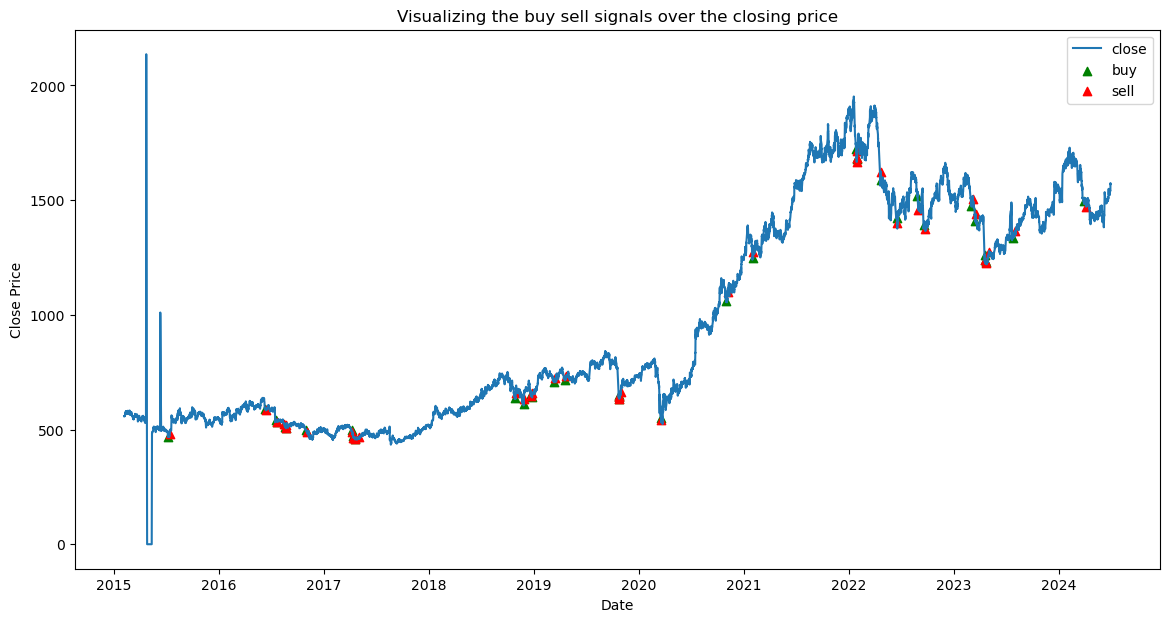

In [25]:
buy_signals = [trade['buy_price'] for trade in trades]
sell_signals = [trade['sell_price'] for trade in trades]
sell_time = [trade['sell_date'] for trade in trades]
buy_time = [trade['buy_date'] for trade in trades]
plt.figure(figsize=(14, 7))
plt.plot(signals_df.index,signals_df['close'],label='close')
plt.scatter(buy_time,buy_signals,marker='^',color='green',label='buy',alpha=1)
plt.scatter(sell_time,sell_signals,marker='^',color='red',label='sell',alpha=1)
plt.title('Visualizing the buy sell signals over the closing price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [26]:
trades_df = pd.DataFrame(trades)
trades_df.head()

,buy_date,buy_price,sell_price,sell_date,profit_loss
0,2015-07-10 14:15:00+05:30,469.20,478.78,2015-07-14 12:15:00+05:30,9.58
1,2016-06-10 15:15:00+05:30,591.00,583.05,2016-06-13 11:15:00+05:30,-7.95
2,2016-07-18 15:15:00+05:30,540.50,534.60,2016-07-22 09:15:00+05:30,-5.90
3,2016-07-22 10:15:00+05:30,534.50,523.08,2016-08-16 09:15:00+05:30,-11.42
4,2016-08-19 12:15:00+05:30,511.68,505.45,2016-08-22 12:15:00+05:30,-6.23


In [27]:
trades_df['buy_date'] = pd.to_datetime(trades_df['buy_date'])
trades_df['sell_date'] = pd.to_datetime(trades_df['sell_date'])
# trades_df.head

# Computing the average returns 


absolute returns = (net return/cost of investment) * 100 % 

In [28]:
def compute_abs_returns(buy_price,sell_price):
    diff = sell_price - buy_price
    roi = (diff/buy_price) * 100 
    return roi

In [29]:
trades_df['absolute_returns'] = trades_df.apply(lambda row: compute_abs_returns(row['buy_price'],row['sell_price']),axis=1) 
trades_df.head()

,buy_date,buy_price,sell_price,sell_date,profit_loss,absolute_returns
0,2015-07-10 14:15:00+05:30,469.20,478.78,2015-07-14 12:15:00+05:30,9.58,2.041773
1,2016-06-10 15:15:00+05:30,591.00,583.05,2016-06-13 11:15:00+05:30,-7.95,-1.345178
2,2016-07-18 15:15:00+05:30,540.50,534.60,2016-07-22 09:15:00+05:30,-5.90,-1.091582
3,2016-07-22 10:15:00+05:30,534.50,523.08,2016-08-16 09:15:00+05:30,-11.42,-2.136576
4,2016-08-19 12:15:00+05:30,511.68,505.45,2016-08-22 12:15:00+05:30,-6.23,-1.217558


In [30]:
total_abs_return = trades_df['absolute_returns'].sum()

In [31]:
print(f"The absolute returns of the trading strategy: {total_abs_return:.2f}%")

The absolute returns of the trading strategy: 16.37%


# Computing beta

In [32]:
nifty_50_df = fetchOHLCExtended('NIFTY 50', "02-02-2015", 'hour')
infy_df = ohlc.copy()

In [33]:

def compute_beta(nifty_50_df, ohlc_df):
    # Ensure data is sorted by date
    nifty_50_df.sort_index(inplace=True)
    ohlc_df.sort_index(inplace=True)
    
    # Calculate daily returns
    nifty_50_df['returns'] = nifty_50_df['close'].pct_change()
    ohlc_df['returns'] = ohlc_df['close'].pct_change()
    
    # Drop NaN values resulting from the pct_change calculation
    nifty_50_df.dropna(subset=['returns'], inplace=True)
    ohlc_df.dropna(subset=['returns'], inplace=True)
    
    # Rename the returns columns for clarity
    nifty_50_df.rename(columns={'returns': 'returns_NIFTY_50'}, inplace=True)
    ohlc_df.rename(columns={'returns': 'returns_STK'}, inplace=True)
    
    # Merge the dataframes on the Date index
    merged_df = pd.merge(nifty_50_df[['returns_NIFTY_50']], ohlc_df[['returns_STK']], left_index=True, right_index=True)
    
    # Replace inf values with NaN and drop them
    merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    merged_df.dropna(inplace=True)
    
    # Print the descriptive statistics of the merged dataframe
    # print(merged_df.describe())
    
    if not merged_df.empty:
        beta, alpha = np.polyfit(merged_df['returns_NIFTY_50'], merged_df['returns_STK'], 1)
        # print(f"The beta value of the stock: {beta}")
    else:
        print("Merged dataframe is empty after removing inf values.")
    return beta

In [34]:
beta = compute_beta(nifty_50_df, infy_df)
print(f"The beta value of Infosys stock: {beta}")


The beta value of Infosys stock: 0.7826854102640437


# Computing the sharpe ratio 

Sharpe ratio = [Fund Return – Risk-Free Return]/Standard Deviation of the fund

In [35]:
nifty_50_avg_df = nifty_50_df.copy()

In [38]:
# Calculate the average market return 

def compute_avg_market_return(df):
    df = df.copy()
    df.sort_index(inplace=True)
    df['returns'] = df['close'].pct_change()
    df.dropna(subset=['returns'], inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    average_market_return = df['returns'].mean()
    annualized_market_return = (1 + average_market_return) ** 252 - 1
    return annualized_market_return

avg_market_return = compute_avg_market_return(nifty_50_avg_df)
print(f"NIFTY 50 market return value (2015-2024): {avg_market_return:.4f}")


def compute_risk_free_returns(avg_market_return,risk_free_rate,beta):
    risk_free_return = risk_free_rate + beta * (avg_market_return - beta)
    return risk_free_return

risk_free_return = compute_risk_free_returns(avg_market_return,risk_free_rate=0.70,beta=beta) 
print(f"Risk free return of nifty 50: {risk_free_return:.4f}")

NIFTY 50 market return value (2015-2024): 0.0177
Risk free return of nifty 50: 0.1013
